In [1]:
###Understanding the training Dataset
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
data=pd.read_csv("D:/GUIDE_Train.csv/GUIDE_Train.csv")
data.head()

,Id,OrgId,IncidentId,AlertId,Timestamp,DetectorId,AlertTitle,Category,MitreTechniques,IncidentGrade,...,ResourceType,Roles,OSFamily,OSVersion,AntispamDirection,SuspicionLevel,LastVerdict,CountryCode,State,City
0,180388628218,0,612,123247,2024-06-04T06:05:15.000Z,7,6,InitialAccess,NaN,TruePositive,...,NaN,NaN,5,66,NaN,NaN,NaN,31,6,3
1,455266534868,88,326,210035,2024-06-14T03:01:25.000Z,58,43,Exfiltration,NaN,FalsePositive,...,NaN,NaN,5,66,NaN,NaN,NaN,242,1445,10630
2,1056561957389,809,58352,712507,2024-06-13T04:52:55.000Z,423,298,InitialAccess,T1189,FalsePositive,...,NaN,NaN,5,66,NaN,Suspicious,Suspicious,242,1445,10630
3,1279900258736,92,32992,774301,2024-06-10T16:39:36.000Z,2,2,CommandAndControl,NaN,BenignPositive,...,NaN,NaN,5,66,NaN,Suspicious,Suspicious,242,1445,10630
4,214748368522,148,4359,188041,2024-06-15T01:08:07.000Z,9,74,Execution,NaN,TruePositive,...,NaN,NaN,5,66,NaN,NaN,NaN,242,1445,10630


In [3]:
data.shape

(9516837, 45)

In [4]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9516837 entries, 0 to 9516836
Data columns (total 45 columns):
 #   Column              Dtype  
---  ------              -----  
 0   Id                  int64  
 1   OrgId               int64  
 2   IncidentId          int64  
 3   AlertId             int64  
 4   Timestamp           object 
 5   DetectorId          int64  
 6   AlertTitle          int64  
 7   Category            object 
 8   MitreTechniques     object 
 9   IncidentGrade       object 
 10  ActionGrouped       object 
 11  ActionGranular      object 
 12  EntityType          object 
 13  EvidenceRole        object 
 14  DeviceId            int64  
 15  Sha256              int64  
 16  IpAddress           int64  
 17  Url                 int64  
 18  AccountSid          int64  
 19  AccountUpn          int64  
 20  AccountObjectId     int64  
 21  AccountName         int64  
 22  DeviceName          int64  
 23  NetworkMessageId    int64  
 24  EmailClusterId      floa

In [5]:
data.isnull().sum()

Id                          0
OrgId                       0
IncidentId                  0
AlertId                     0
Timestamp                   0
DetectorId                  0
AlertTitle                  0
Category                    0
MitreTechniques       5468386
IncidentGrade           51340
ActionGrouped         9460773
ActionGranular        9460773
EntityType                  0
EvidenceRole                0
DeviceId                    0
Sha256                      0
IpAddress                   0
Url                         0
AccountSid                  0
AccountUpn                  0
AccountObjectId             0
AccountName                 0
DeviceName                  0
NetworkMessageId            0
EmailClusterId        9420025
RegistryKey                 0
RegistryValueName           0
RegistryValueData           0
ApplicationId               0
ApplicationName             0
OAuthApplicationId          0
ThreatFamily          9441956
FileName                    0
FolderPath

In [6]:
data['IncidentGrade'].value_counts()

IncidentGrade
BenignPositive    4110817
TruePositive      3322713
FalsePositive     2031967
Name: count, dtype: int64

In [7]:
dup_count=data.duplicated().sum()
dup_count

np.int64(22559)

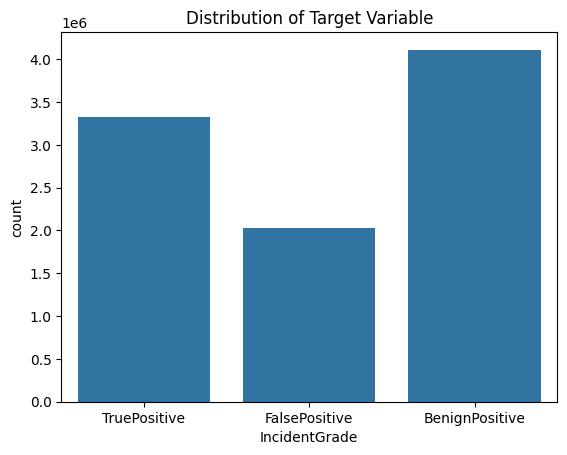

In [8]:
###Data Cleaning and Preprocessing for Train Dataset
# plot Distribution of Target Variable
plt.figure()
sns.countplot(x=data['IncidentGrade'])
plt.title('Distribution of Target Variable')
plt.show()

In [9]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

# Calculating the percentage of missing values for each column
missing_percentage = data.isnull().sum() / len(data) * 100

# List columns with more than 50% missing values
columns_to_drop = missing_percentage[missing_percentage > 50].index
print("Columns with more than 50% missing values are dropped:")
print(columns_to_drop)

# Drop these columns
data.drop(columns=columns_to_drop, axis=1, inplace=True)

Columns with more than 50% missing values are dropped:
Index(['MitreTechniques', 'ActionGrouped', 'ActionGranular', 'EmailClusterId',
       'ThreatFamily', 'ResourceType', 'Roles', 'AntispamDirection',
       'SuspicionLevel', 'LastVerdict'],
      dtype='object')


In [10]:
# Impute missing values for categorical columns
categorical_columns = data.select_dtypes(include=['object','category']).columns
for col in categorical_columns:
    if data[col].isnull().any():
        mode_val = data[col].mode()[0]
        data[col] = data[col].fillna(mode_val)
        print(f"Imputed categorical column '{col}' with mode value: {mode_val}")

Imputed categorical column 'IncidentGrade' with mode value: BenignPositive


In [11]:
# Impute missing values for numeric columns
numeric_columns = data.select_dtypes(include=['int32','float32']).columns
for col in numeric_columns:
    if data[col].isnull().any():
        median_val = data[col].median()
        data[col] = data[col].fillna(median_val)
        print(f"Imputed numeric column '{col}' with median value: {median_val}")

In [12]:
def remove_outliers(data, iqr_multiplier=1.5):
    # Select only numeric columns
    numeric_features = data.select_dtypes(include=['int32', 'int16', 'float32', 'int64', 'float64']).copy()
    for col in numeric_features.columns:
        if numeric_features[col].nunique() > 10:  # Proceed only if there are enough unique values
            Q1 = numeric_features[col].quantile(0.25)  # First quartile
            Q3 = numeric_features[col].quantile(0.75)  # Third quartile
            IQR = Q3 - Q1
            lower_bound = Q1 - iqr_multiplier * IQR
            upper_bound = Q3 + iqr_multiplier * IQR
            # Mark rows as outliers
            outlier_condition = (data[col] < lower_bound) | (data[col] > upper_bound)
            data = data[~outlier_condition]  # Keep only non-outliers
    return data

# Usage
data = remove_outliers(data, iqr_multiplier=1.5)


In [13]:
# Feature Engineering
data['Timestamp'] = pd.to_datetime(data['Timestamp'], errors='coerce')
data['Year'] = data['Timestamp'].dt.year
data['Month'] = data['Timestamp'].dt.month
data['DayOfWeek'] = data['Timestamp'].dt.dayofweek
data['Hour'] = data['Timestamp'].dt.hour

# Drop the 'Timestamp' column
data.drop(columns=['Timestamp'], inplace=True)


In [14]:
id_columns = ['Id', 'OrgId', 'IncidentId', 'AlertId', 'DetectorId', 'DeviceId', 'Sha256', 
              'IpAddress', 'Url', 'AccountSid', 'AccountUpn', 'AccountObjectId', 'AccountName', 
              'DeviceName', 'NetworkMessageId', 'RegistryKey', 'RegistryValueName', 
              'RegistryValueData', 'ApplicationId', 'ApplicationName', 'OAuthApplicationId', 
              'FileName', 'FolderPath', 'ResourceIdName', 'OSFamily', 'OSVersion', 'City', 
              'CountryCode', 'State']

# Exclude ID columns from scaling
numeric_features = data.select_dtypes(include=['int32', 'int16', 'float32', 'int64']).drop(columns=id_columns, errors='ignore')

# Scaling numerical features
scaler = MinMaxScaler()
data[numeric_features.columns] = scaler.fit_transform(numeric_features)


In [15]:
# Define categorical columns to encode
categorical_columns = ['Category', 'IncidentGrade', 'EntityType', 'EvidenceRole']

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Encode categorical columns
for col in categorical_columns:
    if col in data.columns:
        data[col] = label_encoder.fit_transform(data[col].astype(str))  # Convert to string if necessary

# Remove duplicate rows
data.drop_duplicates(inplace=True)


In [16]:
# Define the dataset path
dataset_path = r"D:\Microsoft_CCI.ipynb\GUIDE_Trained.csv"

# Save the dataset
data.to_csv(dataset_path, index=False)
print("Data preprocessing complete and saved.")


Data preprocessing complete and saved.


In [17]:
data

,Id,OrgId,IncidentId,AlertId,DetectorId,AlertTitle,Category,IncidentGrade,EntityType,EvidenceRole,...,ResourceIdName,OSFamily,OSVersion,CountryCode,State,City,Year,Month,DayOfWeek,Hour
24,824633723860,75,478,939479,4,0.006834,5,2,0,1,...,3586,5,66,242,1445,10630,1.0,0.454545,0.000000,0.608696
27,489626273557,0,211,160158,0,0.000000,5,2,0,1,...,3586,5,66,242,1445,10630,1.0,0.454545,0.166667,0.347826
42,231928235439,88,26726,1114326,58,0.097950,4,1,6,0,...,3586,5,66,242,1445,10630,1.0,0.454545,0.000000,0.043478
49,627065226947,0,375,169963,0,0.000000,5,2,0,1,...,3586,5,66,242,1445,10630,1.0,0.454545,0.000000,0.217391
50,249108107265,108,144844,118616,6,0.011390,5,2,5,1,...,3586,5,66,242,1445,10630,1.0,0.454545,0.500000,0.652174
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9516777,206158430958,127,108,1175139,0,0.000000,5,2,0,1,...,3586,5,66,242,1445,10630,1.0,0.454545,0.500000,0.434783
9516799,1486058686131,0,260,540837,7,0.013667,5,2,0,1,...,3586,5,66,242,1445,10630,1.0,0.454545,0.333333,0.565217
9516826,1692217116375,0,440,164344,0,0.000000,5,2,0,1,...,3586,5,66,242,1445,10630,1.0,0.454545,0.500000,0.869565
9516828,1108101564153,0,319,499915,0,0.000000,5,2,0,1,...,3586,5,66,242,1445,10630,1.0,0.454545,0.666667,0.956522


In [18]:
###Data Exploration for Test Dataset
data_1=pd.read_csv("D:/GUIDE_Test.csv/GUIDE_Test.csv")
data_1.head()

C:\Users\sowmi\AppData\Local\Temp\ipykernel_18456\1867256505.py:2: DtypeWarning: Columns (10,11) have mixed types. Specify dtype option on import or set low_memory=False.
  data_1=pd.read_csv("D:/GUIDE_Test.csv/GUIDE_Test.csv")


,Id,OrgId,IncidentId,AlertId,Timestamp,DetectorId,AlertTitle,Category,MitreTechniques,IncidentGrade,...,Roles,OSFamily,OSVersion,AntispamDirection,SuspicionLevel,LastVerdict,CountryCode,State,City,Usage
0,1245540519230,657,11767,87199,2024-06-04T22:56:27.000Z,524,563,LateralMovement,T1021;T1047;T1105;T1569.002,BenignPositive,...,NaN,5,66,NaN,Suspicious,Suspicious,242,1445,10630,Private
1,1400159342154,3,91158,632273,2024-06-03T12:58:26.000Z,2,2,CommandAndControl,NaN,BenignPositive,...,NaN,0,0,NaN,Suspicious,Suspicious,242,1445,10630,Public
2,1279900255923,145,32247,131719,2024-06-08T03:20:49.000Z,2932,10807,LateralMovement,T1021;T1027.002;T1027.005;T1105,BenignPositive,...,NaN,5,66,NaN,Suspicious,Suspicious,242,1445,10630,Public
3,60129547292,222,15294,917686,2024-06-12T12:07:31.000Z,0,0,InitialAccess,T1078;T1078.004,FalsePositive,...,NaN,5,66,NaN,NaN,NaN,242,1445,10630,Public
4,515396080539,363,7615,5944,2024-06-06T17:42:05.000Z,27,18,Discovery,T1087;T1087.002,BenignPositive,...,Suspicious,5,66,NaN,NaN,NaN,242,1445,10630,Public


In [19]:
data_1.shape

(4147992, 46)

In [20]:
data_1.columns

Index(['Id', 'OrgId', 'IncidentId', 'AlertId', 'Timestamp', 'DetectorId',
       'AlertTitle', 'Category', 'MitreTechniques', 'IncidentGrade',
       'ActionGrouped', 'ActionGranular', 'EntityType', 'EvidenceRole',
       'DeviceId', 'Sha256', 'IpAddress', 'Url', 'AccountSid', 'AccountUpn',
       'AccountObjectId', 'AccountName', 'DeviceName', 'NetworkMessageId',
       'EmailClusterId', 'RegistryKey', 'RegistryValueName',
       'RegistryValueData', 'ApplicationId', 'ApplicationName',
       'OAuthApplicationId', 'ThreatFamily', 'FileName', 'FolderPath',
       'ResourceIdName', 'ResourceType', 'Roles', 'OSFamily', 'OSVersion',
       'AntispamDirection', 'SuspicionLevel', 'LastVerdict', 'CountryCode',
       'State', 'City', 'Usage'],
      dtype='object')

In [21]:
data_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4147992 entries, 0 to 4147991
Data columns (total 46 columns):
 #   Column              Dtype  
---  ------              -----  
 0   Id                  int64  
 1   OrgId               int64  
 2   IncidentId          int64  
 3   AlertId             int64  
 4   Timestamp           object 
 5   DetectorId          int64  
 6   AlertTitle          int64  
 7   Category            object 
 8   MitreTechniques     object 
 9   IncidentGrade       object 
 10  ActionGrouped       object 
 11  ActionGranular      object 
 12  EntityType          object 
 13  EvidenceRole        object 
 14  DeviceId            int64  
 15  Sha256              int64  
 16  IpAddress           int64  
 17  Url                 int64  
 18  AccountSid          int64  
 19  AccountUpn          int64  
 20  AccountObjectId     int64  
 21  AccountName         int64  
 22  DeviceName          int64  
 23  NetworkMessageId    int64  
 24  EmailClusterId      floa

In [22]:
data_1.isnull().sum()

Id                          0
OrgId                       0
IncidentId                  0
AlertId                     0
Timestamp                   0
DetectorId                  0
AlertTitle                  0
Category                    0
MitreTechniques       2307104
IncidentGrade               0
ActionGrouped         4146079
ActionGranular        4146079
EntityType                  0
EvidenceRole                0
DeviceId                    0
Sha256                      0
IpAddress                   0
Url                         0
AccountSid                  0
AccountUpn                  0
AccountObjectId             0
AccountName                 0
DeviceName                  0
NetworkMessageId            0
EmailClusterId        4106285
RegistryKey                 0
RegistryValueName           0
RegistryValueData           0
ApplicationId               0
ApplicationName             0
OAuthApplicationId          0
ThreatFamily          4116614
FileName                    0
FolderPath

In [23]:
data_1.duplicated().sum()

np.int64(104)

In [24]:
data_1['IncidentGrade'].value_counts()

IncidentGrade
BenignPositive    1752940
TruePositive      1492354
FalsePositive      902698
Name: count, dtype: int64

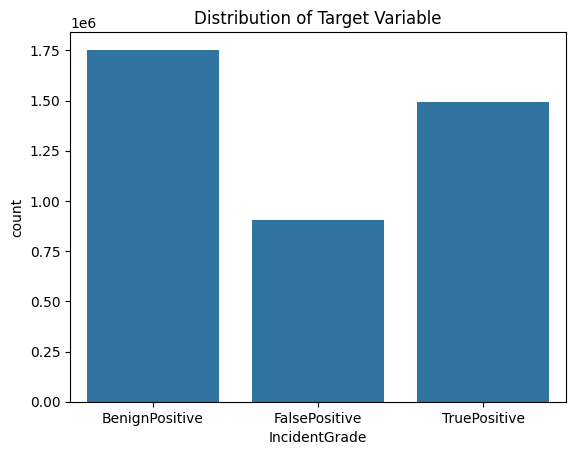

In [25]:
plt.figure()
sns.countplot(x=data_1['IncidentGrade'])
plt.title('Distribution of Target Variable')
plt.show()

In [26]:
# Calculate the percentage of missing values for each column
missing_percentage = data_1.isnull().sum() / len(data_1) * 100

# List columns with more than 50% missing values
columns_to_drop = missing_percentage[missing_percentage > 50].index
print("Columns with more than 50% missing values are dropped:")
print(columns_to_drop)

# Drop these columns
data_1.drop(columns=columns_to_drop, axis=1, inplace=True)

Columns with more than 50% missing values are dropped:
Index(['MitreTechniques', 'ActionGrouped', 'ActionGranular', 'EmailClusterId',
       'ThreatFamily', 'ResourceType', 'Roles', 'AntispamDirection',
       'SuspicionLevel', 'LastVerdict'],
      dtype='object')


In [27]:
# Impute missing values for numeric columns
numeric_columns = data_1.select_dtypes(include=['int32', 'int16', 'float32', 'int64']).columns
for col in numeric_columns:
    if data_1[col].isnull().any():
        median_val = data_1[col].median()
        data_1[col] = data_1[col].fillna(median_val)
        print(f"Imputed numeric column '{col}' with median value: {median_val}")

In [28]:
# Impute missing values for categorical columns
categorical_columns = data_1.select_dtypes(include=['object']).columns
for col in categorical_columns:
    if data_1[col].isnull().any():
        mode_val = data_1[col].mode()[0]
        data_1[col] = data_1[col].fillna(mode_val)
        print(f"Imputed categorical column '{col}' with mode value: {mode_val}")


In [29]:
# Handling Outliers
def outliers(data_1, iqr_multiplier=1.5):
    numeric_features = data_1.select_dtypes(include=['int32', 'int16', 'float32', 'int64', 'float64'])
    for col in numeric_features.columns:
        Q1 = numeric_features[col].quantile(0.25)
        Q3 = numeric_features[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - iqr_multiplier * IQR
        upper_bound = Q3 + iqr_multiplier * IQR
            
        data_1 = data_1[(data_1[col] >= lower_bound) & (data_1[col] <= upper_bound)]
    return data_1

# Usage
data_1 = outliers(data_1, iqr_multiplier=1.5)  # Adjusting the IQR multiplier if necessary

In [30]:
# Feature Engineering: Extracting datetime features
data_1['Timestamp'] = pd.to_datetime(data_1['Timestamp'], errors='coerce')
data_1['Year'] = data_1['Timestamp'].dt.year
data_1['Month'] = data_1['Timestamp'].dt.month
data_1['DayOfWeek'] = data_1['Timestamp'].dt.dayofweek
data_1['Hour'] = data_1['Timestamp'].dt.hour

# Drop the 'Timestamp' and 'Usage' column
data_1.drop(columns=['Timestamp', 'Usage'], inplace=True)


In [31]:
# Scaling numerical features 
numeric_columns = data_1.select_dtypes(include=['int32', 'int16', 'float32', 'int64']).columns

# Scale numeric columns
scaler = MinMaxScaler()
data_1[numeric_columns] = scaler.fit_transform(data_1[numeric_columns])

print("Data scaling complete.")

Data scaling complete.


In [32]:
label_encoder = LabelEncoder()
categorical_columns = ['Category', 'IncidentGrade', 'EntityType', 'EvidenceRole']


In [33]:
for col in categorical_columns:
    if col in data_1.columns:
        data_1[col] = label_encoder.fit_transform(data_1[col].astype(str))  # Convert to string if necessary

# Remove duplicate rows
data_1.drop_duplicates(inplace=True)

In [34]:
# Define the dataset path
dataset_path = r"D:\Microsoft_CCI.ipynb\GUIDE_Test.csv"

# Save the dataset
data_1.to_csv(dataset_path, index=False)
print("Data preprocessing complete and saved.")


Data preprocessing complete and saved.


In [35]:
data_1

,Id,OrgId,IncidentId,AlertId,DetectorId,AlertTitle,Category,IncidentGrade,EntityType,EvidenceRole,...,ResourceIdName,OSFamily,OSVersion,CountryCode,State,City,Year,Month,DayOfWeek,Hour
3,0.035176,0.528571,0.077298,0.558792,0.000000,0.000000,5,1,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.454545,0.333333,0.521739
27,0.281407,0.011905,0.000935,0.571372,0.208791,0.063559,5,2,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.454545,0.166667,0.782609
36,0.346734,0.171429,0.000758,0.546467,0.043956,0.012712,5,2,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.454545,0.333333,0.608696
42,0.819095,0.488095,0.080735,0.090219,0.010989,0.004237,5,2,5,1,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.454545,0.833333,1.000000
53,0.608040,0.214286,0.001021,0.537732,0.000000,0.000000,5,2,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.454545,0.000000,0.869565
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4147886,0.371859,0.211905,0.000126,0.537039,0.000000,0.000000,5,2,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.454545,0.333333,0.695652
4147913,0.226131,0.083333,0.001046,0.780048,0.000000,0.000000,5,2,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.454545,0.166667,0.434783
4147936,0.497487,0.261905,0.000713,0.623384,0.000000,0.000000,5,2,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.454545,0.500000,0.304348
4147940,0.773869,0.150000,0.000733,0.510793,0.000000,0.000000,5,2,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.454545,0.666667,0.695652


In [19]:
###Logistic Regression
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

# Load the dataset
data = pd.read_csv(r"D:\Microsoft_CCI.ipynb\GUIDE_Trained.csv")

# Define features and target
X = data.drop('IncidentGrade', axis=1)
y = data['IncidentGrade']

# Split the data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

# Handle class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

In [20]:
# Initialize logistic regression with class weights
logreg = LogisticRegression(C=10, penalty='l1', solver='saga', max_iter=2000, class_weight='balanced')

# Train the model
logreg.fit(X_train, y_train)

# Evaluate the model
y_pred = logreg.predict(X_val)
print("Classification Report:")
print(classification_report(y_val, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.85      0.71     11709
           1       0.61      0.75      0.67     11262
           2       0.99      0.94      0.96    126942

    accuracy                           0.91    149913
   macro avg       0.74      0.84      0.78    149913
weighted avg       0.93      0.91      0.92    149913

Confusion Matrix:
[[  9916   1524    269]
 [  2178   8458    626]
 [  4252   3915 118775]]


In [3]:
###Decision tree
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from scipy.stats import randint

# Load the dataset
data = pd.read_csv(r"D:\Microsoft_CCI.ipynb\GUIDE_Trained.csv")

# Define features and target variable
X = data.drop('IncidentGrade', axis=1)
y = data['IncidentGrade']

# Split the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)




In [4]:
# Initialize Decision Tree Classifier
dtree = DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=20, min_samples_split=4, 
                                min_samples_leaf=1, max_features='log2', random_state=42)

# Train the model
dtree = dtree.fit(X_train, y_train)

# Predict on validation data
y_pred = dtree.predict(X_val)

# Print results
print("\nClassification Report:")
print(classification_report(y_val, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.87      0.83     11709
           1       0.88      0.87      0.88     11262
           2       0.99      0.98      0.99    126942

    accuracy                           0.97    149913
   macro avg       0.89      0.91      0.90    149913
weighted avg       0.97      0.97      0.97    149913

Confusion Matrix:
[[ 10173    773    763]
 [   945   9787    530]
 [  1569    522 124851]]


In [5]:
###Random Forest Classifier
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from scipy.stats import randint

# Load dataset
data = pd.read_csv(r"D:\Microsoft_CCI.ipynb\GUIDE_Trained.csv")

# Define features and target variable
X = data.drop('IncidentGrade', axis=1)
y = data['IncidentGrade']

# Split the dataset into training and validation sets 
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)



In [6]:

# Initialize Random Forest Classifier 
rf = RandomForestClassifier(n_estimators=200, min_samples_split=2, min_samples_leaf=1, max_features=None, max_depth=30, 
                             bootstrap=True, random_state=42)

rf = rf.fit(X_train, y_train)

# Evaluate the best model on validation data
y_pred = rf.predict(X_val)

# Print results
print("\nClassification Report:")
print(classification_report(y_val, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98     11709
           1       0.97      0.97      0.97     11262
           2       1.00      1.00      1.00    126942

    accuracy                           0.99    149913
   macro avg       0.98      0.98      0.98    149913
weighted avg       0.99      0.99      0.99    149913

Confusion Matrix:
[[ 11418    200     91]
 [   175  10926    161]
 [    97    167 126678]]


In [7]:
###Gradient Boosting Machines - XGBoost
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from functools import partial

# Load dataset
data = pd.read_csv(r"D:\Microsoft_CCI.ipynb\GUIDE_Trained.csv")

# Define features and target variable
X = data.drop('IncidentGrade', axis=1)
y = data['IncidentGrade']

# Split the dataset into training and validation sets with stratification
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)



In [8]:
# Initialize XGBoost Classifier
xgb_model = xgb.XGBClassifier(subsample=0.8, n_estimators=200, max_depth=9, learning_rate=0.2, colsample_bytree=1.0,
                               random_state=42, use_label_encoder=False, eval_metric='logloss')

xgb_model = xgb_model.fit(X_train, y_train)

# Evaluate the model on validation data
y_pred = xgb_model.predict(X_val)

# Print the evaluation results
print("Classification Report:")
print(classification_report(y_val, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_pred))


d:\Microsoft_CCI.ipynb\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:29:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.96      0.95     11709
           1       0.96      0.96      0.96     11262
           2       1.00      1.00      1.00    126942

    accuracy                           0.99    149913
   macro avg       0.97      0.97      0.97    149913
weighted avg       0.99      0.99      0.99    149913

Confusion Matrix:
[[ 11187    298    224]
 [   289  10784    189]
 [   386    201 126355]]


In [9]:
###Best model Selection
import pandas as pd

report = {
    'Model': ['Logistic Regression', 'Decision Tree', 'Random Forest', 'XGBoost'],
    'Accuracy': [0.91, 0.98, 0.99, 0.99],
    'Macro-F1 Score': [0.78, 0.90, 0.98, 0.97],
    'Precision': [0.74, 0.89, 0.98, 0.97],
    'Recall': [0.84, 0.91, 0.98, 0.97]
}

# Convert to DataFrame
data = pd.DataFrame(report)

# Print comparison table
print("Comparison Table:")
print(data.to_string(index=False))

# Find the best model based on Macro-F1 Score
best_model = data.loc[data['Macro-F1 Score'].idxmax()]

# Print the best model
print("\nBest Model Based on Macro-F1 Score:")
print(best_model)


Comparison Table:
              Model  Accuracy  Macro-F1 Score  Precision  Recall
Logistic Regression      0.91            0.78       0.74    0.84
      Decision Tree      0.98            0.90       0.89    0.91
      Random Forest      0.99            0.98       0.98    0.98
            XGBoost      0.99            0.97       0.97    0.97

Best Model Based on Macro-F1 Score:
Model             Random Forest
Accuracy                   0.99
Macro-F1 Score             0.98
Precision                  0.98
Recall                     0.98
Name: 2, dtype: object


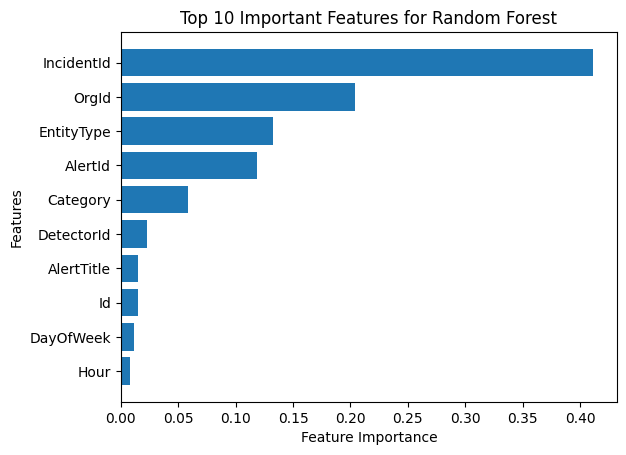


First 5 Misclassified Samples:
                   Id  OrgId  IncidentId  AlertId  DetectorId  AlertTitle  \
135814  1168231106535    227       20583    14966           1    0.002278   
451777   953482744565    152       41714   887287           0    0.000000   
360079   738734378853    195       43057  1045909           0    0.000000   
478460  1451698946728    308       37302   119229           6    0.011390   
74330     68719477523    107         725    65418           1    0.002278   

        Category  EntityType  EvidenceRole  DeviceId  ...  ResourceIdName  \
135814         5           5             1     98799  ...            3586   
451777         5           1             1     98799  ...            3586   
360079         5           0             1     98799  ...            3586   
478460         5           5             1     98799  ...            3586   
74330          5           5             1     98799  ...            3586   

        OSFamily  OSVersion  CountryCode  

In [10]:
###Feature Importance and Error Analysis
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix

# Get feature importances from the best Random Forest model
importances = rf.feature_importances_

# Use the columns from the data
features = X.columns
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})

# Get the top 10 features by importance
top_10_features = feature_importance_df.sort_values(by='Importance', ascending=False).head(10)

# Plot feature importance for the top 10 features
plt.figure()
plt.barh(top_10_features['Feature'], top_10_features['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Top 10 Important Features for Random Forest')
plt.gca().invert_yaxis()  # Invert y-axis to display highest importance at the top
plt.show()

# Identify misclassified samples
misclassified_idx = (y_val != y_pred)

# Extract the misclassified samples
misclassified_samples = X_val[misclassified_idx].copy()

# Display the first 5 misclassified samples
print("\nFirst 5 Misclassified Samples:")
print(misclassified_samples.head(5))

# Evaluate the model's predictions
print("\nClassification Report:")
print(classification_report(y_val, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_val, y_pred))


In [7]:
###Saving the Best Model
import pandas as pd
from joblib import load
from sklearn.metrics import classification_report, confusion_matrix

# Load the saved Random Forest model
model_path = r"D:\Microsoft_CCI.ipynb\model.pkl"
best_rf = load(model_path)

# Load the test dataset
test_data_path = r"D:\Microsoft_CCI.ipynb\GUIDE_Test.csv"
test_data = pd.read_csv(test_data_path)

# Separate features and target from test data
X_test = test_data.drop('IncidentGrade', axis=1)
y_test = test_data['IncidentGrade']

# Make predictions on the test set
y_test_pred = best_rf.predict(X_test)

# Evaluate the model on the test set
print("\nClassification Report on Test Data:")
report = classification_report(y_test, y_test_pred, output_dict=True)
print(classification_report(y_test, y_test_pred))

# Extract macro-F1 score, precision, and recall from the report
macro_f1 = report['macro avg']['f1-score']
macro_precision = report['macro avg']['precision']
macro_recall = report['macro avg']['recall']

print("\nMacro-F1 Score: {:.2f}".format(macro_f1))
print("Macro Precision: {:.2f}".format(macro_precision))
print("Macro Recall: {:.2f}".format(macro_recall))

# Confusion Matrix
print("\nConfusion Matrix on Test Data:")
print(confusion_matrix(y_test, y_test_pred))







Classification Report on Test Data:
              precision    recall  f1-score   support

           0       0.59      0.80      0.68     24124
           1       0.86      0.12      0.22     21252
           2       0.94      0.97      0.96    303765

    accuracy                           0.91    349141
   macro avg       0.80      0.63      0.62    349141
weighted avg       0.91      0.91      0.89    349141


Macro-F1 Score: 0.62
Macro Precision: 0.80
Macro Recall: 0.63

Confusion Matrix on Test Data:
[[ 19200    345   4579]
 [  4693   2655  13904]
 [  8802     71 294892]]


In [4]:
###Evaluation of Selected Random Forest Model on Test Data
import pandas as pd
from joblib import load
from sklearn.metrics import classification_report, confusion_matrix

# Load the saved Random Forest model
model_path = r"D:\Microsoft_CCI.ipynb\model.pkl"
best_rf = load(model_path)

# Load the test dataset
test_data_path = r"D:\Microsoft_CCI.ipynb\GUIDE_Test.csv"
test_data = pd.read_csv(test_data_path)

# Separate features and target from test data
X_test = test_data.drop('IncidentGrade', axis=1)
y_test = test_data['IncidentGrade']

# Make predictions on the test set
y_test_pred = best_rf.predict(X_test)

# Evaluate the model on the test set
print("\nClassification Report on Test Data:")
report = classification_report(y_test, y_test_pred, output_dict=True)
print(classification_report(y_test, y_test_pred))

# Extract macro-F1 score, precision, and recall from the report
macro_f1 = report['macro avg']['f1-score']
macro_precision = report['macro avg']['precision']
macro_recall = report['macro avg']['recall']

print("\nMacro-F1 Score: {:.2f}".format(macro_f1))
print("Macro Precision: {:.2f}".format(macro_precision))
print("Macro Recall: {:.2f}".format(macro_recall))

# Confusion Matrix
print("\nConfusion Matrix on Test Data:")
print(confusion_matrix(y_test, y_test_pred))



Classification Report on Test Data:
              precision    recall  f1-score   support

           0       0.59      0.80      0.68     24124
           1       0.86      0.12      0.22     21252
           2       0.94      0.97      0.96    303765

    accuracy                           0.91    349141
   macro avg       0.80      0.63      0.62    349141
weighted avg       0.91      0.91      0.89    349141


Macro-F1 Score: 0.62
Macro Precision: 0.80
Macro Recall: 0.63

Confusion Matrix on Test Data:
[[ 19200    345   4579]
 [  4693   2655  13904]
 [  8802     71 294892]]
